In [1]:
import tqdm
import pickle
import sys
import os
import pyreadr
import numpy as np
import pandas as pd
from itertools import chain
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Patch
import rasterio
from rasterio.transform import Affine
from rasterio.windows import from_bounds
from datetime import datetime
sys.path.append('../utils/')
from model_utils import m_numpy
from eval_utils import fast_auc
np.random.seed(123)

In [2]:
spN = 13
area = "all"
priortype = "app20232024"
path_project = "/scratch/project_2003104/gtikhono/realtime_birds"
dir_orig_data = "orig_data"
dir_data = "data"
df_sp_model = pd.read_csv(os.path.join(path_project, dir_data, "modeled_species.csv"))
spnames = list(df_sp_model.sort_values("p24", ascending=False).species[:min(df_sp_model.shape[0], spN)])
p = len(spnames)
print(p, spnames)

13 ['107_fringilla_coelebs', '170_parus_major', '187_phylloscopus_trochilus', '249_turdus_merula', '083_cyanistes_caeruleus', '248_turdus_iliacus', '105_ficedula_hypoleuca', '216_spinus_spinus', '251_turdus_pilaris', '098_erithacus_rubecula', '064_chloris_chloris', '131_larus_canus', '089_dendrocopos_major']


# Set parameters

In [3]:
sci_data = pd.read_csv("/users/gtikhono/realtime-birds/data/baselocations.csv")
min_lon, max_lon = np.min(sci_data.lon)-0.5, np.max(sci_data.lon)+1.1
min_lat, max_lat = np.min(sci_data.lat)-0.5, np.max(sci_data.lat)+0.5
n_sci = sci_data.shape[0]
T = sci_data.n.max() * 5 + 3
sci_days = np.zeros([n_sci, T], dtype=int)
for i in range(n_sci):
    ind = np.arange(5*sci_data.n[i]+3)
    ind = np.round(np.linspace(0, T-1, 5*sci_data.n[i]+3)).astype(int)
    sci_days[i, ind] = 1 

r_search = 50
sites_per_day = 10
r_day = 10
r_min = 0.5 # change to 0.5

tau = 400 # sigma = 1/sqrt(tau)
gamma = 0.95
res = 0.01

In [4]:
# sci_data.drop("person", axis=1).to_csv("/users/gtikhono/realtime-birds/baselocations.csv", index=False)

In [5]:
path_migration = os.path.join(path_project, dir_data, "migration_prior_params.pickle")
with open(path_migration, "rb") as handle:
    m_params = pickle.load(handle)
index_style = dict(zip(m_params.index, [x.lower().replace(" ", "_") for x in m_params.index]))
m_params.rename(index=index_style, inplace=True)

In [6]:
sp = spnames[0]
path_sp = os.path.join(path_project, dir_data, "species", sp)
with rasterio.open(os.path.join(path_sp, sp + "_a.tif")) as src:
    window = from_bounds(min_lon, min_lat, max_lon, max_lat, transform=src.transform)
    height, width = window.round_lengths().height, window.round_lengths().width
    transform = src.window_transform(window)

a_prior = np.zeros([height, width, p])
a_post = np.zeros([height, width, p])
for j in tqdm.tqdm(range(p)):
    sp = spnames[j]
    path_sp = os.path.join(path_project, dir_data, "species", sp)
    with rasterio.open(os.path.join(path_sp, sp + "_a.tif")) as src:
        a_prior[:,:,j] = src.read(1, window=window)      
    with rasterio.open(os.path.join(path_sp, sp + f"_a_{priortype}.tif")) as src:
        a_post[:,:,j] = src.read(1, window=window)

delta = np.abs(a_prior - a_post)
_, lat_grid = rasterio.transform.xy(transform, np.arange(height), np.zeros(height))
lon_grid, _ = rasterio.transform.xy(transform, np.zeros(width), np.arange(width))

100%|██████████| 13/13 [00:36<00:00,  2.82s/it]


In [7]:
coords_sci = []
idx_sci = []
in_bounds = ~np.isnan(a_prior).any(axis=2)
# while len(coords_sci) < n_sci:
#     lon = np.random.uniform(lon_grid[0], lon_grid[-1])
#     lat = np.random.uniform(lat_grid[-1], lat_grid[0])
#     lon, lat = sci_data.loc[]
#     row, col = rasterio.transform.rowcol(transform, lon, lat)
#     if in_bounds[row, col]:
#         coords_sci.append([lon, lat])
#         idx_sci.append([row, col])

for i in range(n_sci):
    lon, lat = sci_data.loc[i, ["lon","lat"]]
    row, col = rasterio.transform.rowcol(transform, lon, lat)
    coords_sci.append([lon, lat])
    idx_sci.append([row, col])
coords_sci = np.array(coords_sci)
idx_sci = np.array(idx_sci)

In [8]:
def make_mask(R, scale=10):
    R_cells = int(scale * R)
    y, x = np.ogrid[-R_cells:R_cells+1, -R_cells:R_cells+1]
    mask = (x**2 + y**2) <= R_cells**2
    return mask

def apply_mask(target, row, col, mask, invert=False, inplace=False):
    if inplace == False:
        out = target.copy()
    else:
        out = target
    H, W = target.shape
    k = mask.shape[0]
    R = k // 2
    r0 = max(0, row - R)
    r1 = min(H, row + R + 1)
    c0 = max(0, col - R)
    c1 = min(W, col + R + 1)
    mr0 = R - (row - r0)
    mr1 = mr0 + (r1 - r0)
    mc0 = R - (col - c0)
    mc1 = mc0 + (c1 - c0)
    m = mask[mr0:mr1, mc0:mc1]
    if invert:
        out[r0:r1, c0:c1] &= ~m
    else:
        out[:] = 0
        out[r0:r1, c0:c1] = target[r0:r1, c0:c1] & m
    if inplace == False:
        return out    

search_circle = make_mask(r_search)
sci_mask = np.ones([height, width, n_sci], bool)
for i in tqdm.tqdm(range(n_sci)):
    sci_mask[:,:,i] = apply_mask(sci_mask[:,:,i], idx_sci[i,0], idx_sci[i,1], search_circle)
sci_mask = sci_mask * in_bounds[:,:,None]
search_map = sci_mask.any(axis=2)
day_circle = make_mask(r_day)
site_circle = make_mask(r_min)

100%|██████████| 17/17 [00:01<00:00, 15.88it/s]


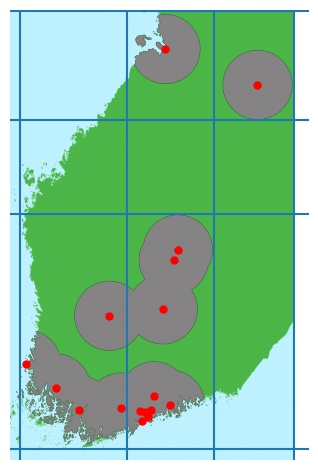

In [9]:
cmap_base = ListedColormap(['#BEF2FF', '#4CB648'])
circle_cmap = ListedColormap(['#858383'])
fig, ax = plt.subplots()
ax.imshow(in_bounds, cmap=cmap_base, origin='upper')
alpha_mask = np.ma.masked_where(~search_map, search_map)
ax.imshow(alpha_mask, cmap=circle_cmap, alpha=1, origin='upper')
y, x = rasterio.transform.rowcol(transform, coords_sci[:,0], coords_sci[:,1])
ax.plot(x, y, 'o', color='red', markersize=5)
plt.axis('off')
plt.tight_layout()
plt.axhline(rasterio.transform.rowcol(transform, 15, 62.8)[0])
plt.axhline(rasterio.transform.rowcol(transform, 15, 59.8)[0])
plt.axvline(rasterio.transform.rowcol(transform, 27, 62.8)[1])
plt.axvline(rasterio.transform.rowcol(transform, 21, 62.8)[1])

plt.axhline(rasterio.transform.rowcol(transform, 15, 65.4)[0])
plt.axhline(rasterio.transform.rowcol(transform, 15, 64)[0])
plt.axvline(rasterio.transform.rowcol(transform, 29.5, 62.8)[1])
plt.axvline(rasterio.transform.rowcol(transform, 24.3, 62.8)[1])
plt.show()

In [10]:
min_lon, max_lon, min_lat, max_lat

(20.675699855413463, 29.44239504215551, 59.65625663567612, 65.41069815831304)

# Calculate locations based on utility

In [11]:
sci_id, idx = [None]*T, [None]*T
global_mask = in_bounds.copy() # prevents searching near previously searched sites

grid_vals = np.arange(0, 1 + res, res) 
grid_max_idx = len(grid_vals) - 1
log_kernel_grid = np.zeros((len(grid_vals), len(grid_vals), p))
grid_idx_prior = np.clip(np.round(a_prior / res).astype(int), 0, grid_max_idx)
grid_idx_post = np.clip(np.round(a_post / res).astype(int), 0, grid_max_idx)
jday_0 = 121
migration_threshold = 0.75

repulsion_grids = []
repulsion = np.ones_like(a_prior, dtype=np.float32)
for t in range(T):
    m_mat = np.stack([m_numpy(lat_grid, jday_0+t, m_params.loc[spnames[j]][:6].to_numpy()) for j in range(p)], axis=1)
    m_mask = m_mat > migration_threshold
    m_mask = np.broadcast_to(m_mask[:,None,:], delta.shape)
    U_active = np.sum(delta * m_mask * repulsion, axis=2)
    
    sci_id_day, idx_day = [None] * n_sci, [None] * n_sci
    # should permute this order across days, np.shuffle
    ind_sci_active = np.where(sci_days[:,t])[0]
    for i in tqdm.tqdm(ind_sci_active, desc=f"Day {t+1}/{T}"):
        sci_id_day[i] = i #sci_data.person_code[i]
        idx_i = np.zeros([sites_per_day, 2], int)
        # Get the first study location for scientist i
        U_local = U_active * sci_mask[:,:,i] * global_mask
        idx_i[0] = np.unravel_index(np.nanargmax(U_local), [height,width])
        global_mask = apply_mask(global_mask, idx_i[0,0], idx_i[0,1], site_circle, invert=True)
        # exclude cells further than r_day away
        local_mask = apply_mask(sci_mask[:,:,i], idx_i[0,0], idx_i[0,1], day_circle)
        U_active_local = U_active * local_mask
        # search for additional cells in a neighborhood
        for k in range(1, sites_per_day):
            U_local = U_active_local * global_mask
            idx_i[k] = np.unravel_index(np.nanargmax(U_local), [height,width])
            global_mask = apply_mask(global_mask, idx_i[k,0], idx_i[k,1], site_circle, invert=True)
        idx_day[i] = idx_i

    sci_id[t] = [sci_id_day[i] for i in ind_sci_active]
    idx[t] = [idx_day[i] for i in ind_sci_active]

    idx_arr = np.concatenate(idx[t])
    prior_last = a_prior[idx_arr[:,0], idx_arr[:,1], :]
    post_last = a_post[idx_arr[:,0], idx_arr[:,1], :]
    m_mask_last = m_mask[idx_arr[:,0], idx_arr[:,1], :]
    d2_prior = np.square(grid_vals[:,None,None] - prior_last[None,:,:])
    d2_post  = np.square(grid_vals[:,None,None] - post_last[None,:,:])
    d2 = d2_prior[:,None,:,:] + d2_post[None,:,:,:] # res**-2 x M x P
    d2_masked = d2 * m_mask_last
    log_kernel = np.log1p(-gamma * np.exp(-0.5 * tau * d2_masked))
    log_kernel_grid = 1*log_kernel_grid + np.sum(log_kernel, axis=2)

    kernel_grid = np.exp(log_kernel_grid)
    repulsion = np.empty_like(a_prior, dtype=np.float32)
    for j in range(p):
        repulsion[:,:,j] = kernel_grid[grid_idx_prior[:,:,j], grid_idx_post[:,:,j], j]
    #log_repulsion = log_kernel_grid[grid_idx_prior, grid_idx_post]
    repulsion_grids.append(kernel_grid)

/tmp/gtikhono/4449408/ipykernel_3014461/1978647932.py:7: RuntimeWarning: invalid value encountered in cast
  grid_idx_prior = np.clip(np.round(a_prior / res).astype(int), 0, grid_max_idx)
/tmp/gtikhono/4449408/ipykernel_3014461/1978647932.py:8: RuntimeWarning: invalid value encountered in cast
  grid_idx_post = np.clip(np.round(a_post / res).astype(int), 0, grid_max_idx)
Day 28/28: 100%|██████████| 17/17 [00:19<00:00,  1.15s/it]


In [14]:
def collect_results(idx, sci_id):
    records = []
    T = len(idx)
    for t in tqdm.tqdm(range(T)):
        for i in range(len(idx[t])):
            sid = sci_id[t][i]
            for j, rc in enumerate(idx[t][i]):
                row, col = rc
                lat, lon = lat_grid[row], lon_grid[col]
                records.append((t, sid, j, lat, lon, row, col))
    return pd.DataFrame(records, columns=["t", "sci_id", "exp_id", "lat", "lon", "row", "col"])

res = collect_results(idx, sci_id)
res.insert(np.where(res.columns=="sci_id")[0][0], "person_code",  sci_data.loc[res.sci_id, "person_code"].reset_index(drop=True))
migration_sel = pd.DataFrame(dict(zip(spnames, [m_numpy(res.lat.values, jday_0+res.t, m_params.loc[spnames[j]][:6].to_numpy()) for j in range(p)])))
prior_sel = pd.DataFrame(a_prior[res["row"], res["col"], :], columns=spnames)
post_sel = pd.DataFrame(a_post[res["row"], res["col"], :], columns=spnames)
timestamp = datetime.now().strftime('%m%d_%H%M%S')
res_filename = f"/users/gtikhono/realtime-birds/data/sel_loc_{area}_{priortype}_sp{p:03d}_{timestamp}.csv"
migration_filename = f"/users/gtikhono/realtime-birds/data/migration_{area}_{priortype}_sp{p:03d}_{timestamp}.csv"
prior_filename = f"/users/gtikhono/realtime-birds/data/prior_{area}_{priortype}_sp{p:03d}_{timestamp}.csv"
post_filename = f"/users/gtikhono/realtime-birds/data/post_{area}_{priortype}_sp{p:03d}_{timestamp}.csv"
res.to_csv(res_filename, index=False)
migration_sel.to_csv(migration_filename, index=False)
prior_sel.to_csv(prior_filename, index=False)
post_sel.to_csv(post_filename, index=False)
print("saved", res_filename)

100%|██████████| 28/28 [00:00<00:00, 6448.88it/s]

saved /users/gtikhono/realtime-birds/data/sel_loc_all_app20232024_sp013_0429_235607.csv


In [16]:
pd.DataFrame(dict(zip(spnames, [m_numpy(res.lat.values, jday_0+res.t, m_params.loc[spnames[j]][:6].to_numpy()) for j in range(p)])))

,107_fringilla_coelebs,170_parus_major,187_phylloscopus_trochilus,249_turdus_merula,083_cyanistes_caeruleus,248_turdus_iliacus,105_ficedula_hypoleuca,216_spinus_spinus,251_turdus_pilaris,098_erithacus_rubecula,064_chloris_chloris,131_larus_canus,089_dendrocopos_major
0,0.938707,1.0,0.148131,0.998185,1.0,0.872269,0.082692,0.990181,0.766725,0.579882,1.0,0.708532,1.0
1,0.938796,1.0,0.149256,0.998211,1.0,0.873258,0.083022,0.990238,0.767551,0.581035,1.0,0.709513,1.0
2,0.938632,1.0,0.147183,0.998162,1.0,0.871428,0.082412,0.990133,0.766025,0.578905,1.0,0.707701,1.0
3,0.938536,1.0,0.145983,0.998133,1.0,0.870352,0.082058,0.990071,0.765132,0.577662,1.0,0.706642,1.0
4,0.938673,1.0,0.147699,0.998174,1.0,0.871887,0.082565,0.990159,0.766407,0.579438,1.0,0.708155,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505,0.968504,1.0,0.999144,0.999995,1.0,0.999646,0.862508,0.999598,0.960245,0.989966,1.0,0.979246,1.0
2506,0.968288,1.0,0.999112,0.999995,1.0,0.999632,0.860704,0.999586,0.959364,0.989664,1.0,0.978702,1.0
2507,0.968539,1.0,0.999149,0.999995,1.0,0.999648,0.862801,0.999600,0.960388,0.990014,1.0,0.979334,1.0
2508,0.968579,1.0,0.999155,0.999996,1.0,0.999650,0.863130,0.999602,0.960547,0.990068,1.0,0.979433,1.0


In [ ]:
G1, G2 = np.meshgrid(grid_vals, grid_vals, indexing='ij')
delta_grid = np.abs(G1 - G2)
repulsion_grids.insert(0, np.ones_like(repulsion_grids[0]))

In [ ]:
# j = 2

# fig, axs = plt.subplots(T, 4, figsize=(12, 3*T))
# for ax_row in axs:
#     for ax in ax_row:
#         ax.set_aspect('equal')

# diff = a_post[:,:,j] - a_prior[:,:,j]
# for t in tqdm.tqdm(range(T)):
#     U = delta_grid * repulsion_grids[t][:,:,j]
#     im0 = axs[t, 0].imshow(U.T, origin="lower")
#     tick_locs = np.linspace(0, 100, 6).astype(int)
#     tick_labels = [f"{v/100:.1f}" for v in tick_locs]
#     axs[t, 0].set_xticks(tick_locs)
#     axs[t, 0].set_xticklabels(tick_labels)
#     axs[t, 0].set_yticks(tick_locs)
#     axs[t, 0].set_yticklabels(tick_labels)

#     repulsion = repulsion_grids[t][grid_idx_prior[:,:,j], grid_idx_post[:,:,j], j]
#     repulsion = np.where(in_bounds, repulsion, np.nan)
#     im1 = axs[t, 1].imshow(np.log(delta[:,:,j] * repulsion + 1e-12), origin="upper", vmin = -20, vmax=0)

#     im2 = axs[t, 2].imshow(diff, vmin=-1, vmax=1, cmap="RdBu_r", origin="upper")
#     axs[t, 2].scatter(res.col[res.t<t], res.row[res.t<t], facecolors='none', edgecolors='grey', s=10)
#     axs[t, 2].scatter(res.col[res.t==t], res.row[res.t==t], facecolors='none', edgecolors='blue', s=10)

#     axs[t, 3].scatter(prior_sel.loc[res.t<t, spnames[j]], post_sel.loc[res.t<t, spnames[j]], color="grey", s=10)
#     axs[t, 3].scatter(prior_sel.loc[res.t==t, spnames[j]], post_sel.loc[res.t==t, spnames[j]], color="blue", s=10)

#     for k in [1, 2]:
#         axs[t, k].set_xticks([])
#         axs[t, k].set_yticks([])
#     for k in [0, 3]:
#         axs[t, k].set_xlabel("Prior")
#         axs[t, k].set_ylabel("Posterior")
#     if t == 0:
#         axs[0, 0].set_title("Utility (probability space)")
#         axs[0, 1].set_title("Log Utility Map")
#         axs[0, 2].set_title("Posterior - Prior")
#         axs[0, 3].set_title("Selected Probabilities")
#         im_handles = [im0, im1, im2]
        
# fig.canvas.draw()
# xd = [0.05, 0.01, -0.03]
# for col, im in enumerate(im_handles):
#     ax = axs[-1, col] 
#     box = ax.get_position()
#     cax = fig.add_axes([
#         box.x0 - xd[col],
#         box.y0 - 0.15,
#         box.width,
#         0.015
#     ])
#     cb = fig.colorbar(im, cax=cax, orientation="horizontal")

# plt.suptitle("Design for " + spnames[j], fontsize=18)
# plt.tight_layout()
# plt.show()

In [ ]:
# j = 2
# diff = a_post[:,:,j] - a_prior[:,:,j]

# for t in tqdm.tqdm(range(T)):
#     fig, axs = plt.subplots(1, 4, figsize=(12, 3))
#     for ax in axs:
#         ax.set_aspect('equal')
#     U = delta_grid * repulsion_grids[t][:,:,j]
#     im0 = axs[0].imshow(U.T, origin="lower")
#     tick_locs = np.linspace(0, 100, 6).astype(int)
#     tick_labels = [f"{v/100:.1f}" for v in tick_locs]
#     axs[0].set_xticks(tick_locs)
#     axs[0].set_xticklabels(tick_labels)
#     axs[0].set_yticks(tick_locs)
#     axs[0].set_yticklabels(tick_labels)

#     repulsion = repulsion_grids[t][grid_idx_prior[:,:,j], grid_idx_post[:,:,j], j]
#     repulsion = np.where(in_bounds, repulsion, np.nan)
#     im1 = axs[1].imshow(np.log(delta[:,:,j] * repulsion + 1e-12), origin="upper", vmin = -20, vmax=0)

#     im2 = axs[2].imshow(diff, vmin=-1, vmax=1, cmap="RdBu_r", origin="upper")
#     axs[2].scatter(res.col[res.t<t], res.row[res.t<t], facecolors='none', edgecolors='grey', s=10)
#     axs[2].scatter(res.col[res.t==t], res.row[res.t==t], facecolors='none', edgecolors='blue', s=10)

#     axs[3].scatter(prior_sel.loc[res.t<t, spnames[j]], post_sel.loc[res.t<t, spnames[j]], color="grey", s=10)
#     axs[3].scatter(prior_sel.loc[res.t==t, spnames[j]], post_sel.loc[res.t==t, spnames[j]], color="blue", s=10)

#     for k in [1, 2]:
#         axs[k].set_xticks([])
#         axs[k].set_yticks([])
#     for k in [0, 3]:
#         axs[k].set_xlabel("Prior")
#         axs[k].set_ylabel("Posterior")
#     axs[0].set_title("Utility (probability space)")
#     axs[1].set_title("Log Utility Map")
#     axs[2].set_title("Posterior - Prior")
#     axs[3].set_title("Selected Probabilities")
#     im_handles = [im0, im1, im2]
#     plt.tight_layout()
#     plt.show()


# Add in better error handling if no valid sites

In [ ]:
fig, axs = plt.subplots(p, 3, figsize=(12, 3 * p))  # p rows, 3 columns
cmap = plt.cm.tab20c
colors = [cmap(i % cmap.N) for i in range(T)]

for j in tqdm.tqdm(range(p)):
    axs[j, 0].hist(prior_sel[spnames[j]])
    axs[j, 0].set_title(f"Prior: {spnames[j]}")
    axs[j, 0].set_xlim(-0.025, 1.025)

    axs[j, 1].hist(post_sel[spnames[j]])
    axs[j, 1].set_title(f"Posterior: {spnames[j]}")
    axs[j, 1].set_xlim(-0.025, 1.025)

    for t_val in range(T):
        mask = res["t"] == t_val
        axs[j, 2].scatter(prior_sel.loc[mask, spnames[j]],
                          post_sel.loc[mask, spnames[j]],
                          color=colors[t_val], facecolors="none")
    axs[j, 2].plot([0, 1], [1, 0], color="black", linewidth=1)
    axs[j, 2].set_xlim(-0.025, 1.025)
    axs[j, 2].set_ylim(-0.025, 1.025)
    axs[j, 2].set_title(f"Prior vs Post: {spnames[j]}")

legend_handles = [Patch(color=colors[t], label=f"{t+1}") for t in range(T)]
fig.legend(handles=legend_handles, title="Day", loc='upper right', bbox_to_anchor=(1.02, 0.96))

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

In [ ]:
sid

In [ ]:
cmap_base = ListedColormap(['#BEF2FF', '#4CB648'])
circle_cmap = ListedColormap(['#cccccc'])

n_cols = 3
n_rows = (T + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()

for t in tqdm.tqdm(range(T)):
    ax = axes[t] if T > 1 else axes
    ax.imshow(in_bounds, cmap=cmap_base, origin='upper')
    alpha_mask = np.ma.masked_where(~search_map, search_map)
    ax.imshow(alpha_mask, cmap=circle_cmap, alpha=1, origin='upper')

    for i in range(n_sci):
        center = coords_sci[i]
        y, x = rasterio.transform.rowcol(transform, center[0], center[1])
        color = plt.cm.prism(i)
        ax.scatter(x, y, color=color, marker='x', s=50)

    for t_prev in range(t + 1):
        alpha_val = 0.1 if t_prev < t else 1.0
        for i, sid in enumerate(sci_id[t_prev]):
            center = coords_sci[sid]
            y, x = rasterio.transform.rowcol(transform, center[0], center[1])
            color = plt.cm.prism(i)        

            neighbors = np.array(idx[t_prev][i])
            ax.scatter(neighbors[:, 1], neighbors[:, 0], facecolor=color, edgecolors=color, s=40, alpha=alpha_val)
            if alpha_val>0.5:
                for point in neighbors:
                    ax.plot([x, point[1]], [y, point[0]], color=color, linewidth=0.8, linestyle="dashed", alpha=alpha_val)

    ax.set_title(f"Day {t+1}")
    ax.axis('off')
    
for t in range(T, len(axes)):
    axes[t].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6,7))
plt.imshow(in_bounds, cmap=cmap_base, origin='upper')
plt.scatter(res["col"], res["row"], marker='x', s=25, color="black");
plt.axis('off')
plt.title("Final Locations");

In [ ]:
AUCs = {}
m = 5
n = post_sel.shape[0]

for j in range(p):
    p_prior = prior_sel[spnames[j]].values
    p_post = post_sel[spnames[j]].values
    Y_sim = np.random.uniform(0,1,[n,m]) <= p_post[:,None]
    Y_sim = Y_sim.flatten().astype(int)
    prior_pred = np.repeat(p_prior, m)
    post_pred = np.repeat(p_post, m)
    
    #
    # remove after resolving edge case where there are no positive utilities and we return a point out-of-bounds
    #
    sel = (~np.isnan(prior_pred))*(~np.isnan(post_pred))
    AUCs[spnames[j]] = [fast_auc(Y_sim[sel], prior_pred[sel]), fast_auc(Y_sim[sel], post_pred[sel])]

AUCs = pd.DataFrame(AUCs, index=["prior", "post"]).T
display(AUCs.round(2))
display(AUCs.mean().round(2))

In [ ]:
plt.figure(0)
plt.imshow(in_bounds, cmap=cmap_base, origin='upper')
plt.scatter(res["col"], res["row"], marker='x', s=25, color="black");
plt.axis('off')
plt.title("Final Locations");

for j in tqdm.tqdm(range(p)):
    plt.figure(j+1)
    tmp = 0*a_prior[:,:,j]
    tmp[(a_prior[:,:,j] < 0.25)*(a_post[:,:,j] > 0.75)] = 1
    tmp[(a_prior[:,:,j] > 0.75)*(a_post[:,:,j] < 0.25)] = -1
    plt.imshow(tmp, cmap="RdBu_r")
    y_pos, x_pos = np.where(tmp > 0)
    plt.scatter(x_pos, y_pos, marker='x', s=20, color="red")
    y_pos, x_pos = np.where(tmp < 0)
    plt.scatter(x_pos, y_pos, marker='x', s=20, color="blue")
    plt.title(spnames[j])
    plt.axis('off')

# Randomize locations post-hoc for scientists to prevent bias from sampling all positive or all negative on the same day?